In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sdm_eurec4a.visulization import set_custom_rcParams, adjust_lightness_array
import sdm_eurec4a.input_processing.models as smodels

from tqdm import tqdm
from typing import Dict
from scipy.optimize import Bounds
import warnings
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from sdm_eurec4a import RepositoryPath
from pathlib import Path

from sdm_eurec4a.reductions import mean_and_stderror_of_mean

from sdm_eurec4a.visulization import set_custom_rcParams, adjust_lightness_array, label_from_attrs
from sdm_eurec4a.identifications import match_clouds_and_cloudcomposite
from sdm_eurec4a.conversions import msd_from_psd_dataarray, psd_from_msd_dataarray

warnings.filterwarnings("ignore")

default_colors = set_custom_rcParams()
dark_colors = adjust_lightness_array(default_colors, 0.7)

In [2]:

class LnParameters():

    def __init__(self, mu, sigma, scale):
        self.parameters = dict(
            mu = mu, 
            sigma = sigma, 
            scale = scale,
            )

    @property
    def custom_parameters(self):
        '''Return the parameters in a dictionary with custom keys.
        Keys are:
        - mu1
        - sigma1
        - scale_factor1
        '''
        result = dict(
            mu1 = self.parameters['mu'],
            sigma1 = self.parameters['sigma'],
            scale_factor1 = self.parameters['scale']
        )
        return result

    @property
    def scipy_parameters(self):
        result = dict(
            s = self.parameters['sigma'],
            loc = self.parameters['mu'],
            scale = self.parameters['scale'],
        )
        return result

    @property
    def geom_parameters(self):
        result = dict(
            geomean = self.parameters['mu'],
            geosig = self.parameters['sigma'],
            scalefac = self.parameters['scale'],
        )
        return result

    @property
    def normal_parameters(self):
        result = dict(
            mu = self.parameters['mu'],
            sigma = self.parameters['sigma'],
            scale = self.parameters['scale'],
        )
        return result



def mass_from_number(t: np.ndarray, y: np.ndarray) -> np.ndarray:
    return 4/3 * np.pi * t**3 * y


In [3]:
lower = 1e-2
upper = 10
N = 100000
x = np.linspace(lower, upper, N)
x1 = np.linspace(lower, upper, N*2)
x2 = np.logspace(np.log10(lower), np.log10(upper), N)
x3 = np.logspace(np.log(lower), np.log(upper), N, base = np.exp(1))

params = LnParameters(3, 2, 3)

results = dict()
for ps in ['direct', 'geometric', 'exact']:
    results[ps] = dict()
    for space in ['linear', 'ln', 'cleo']:
        results[ps][space] = smodels.log_normal_distribution_all(
            x=x,
            parameter_space=ps,
            space = space,
            mu = params.parameters['mu'],
            sigma = params.parameters['sigma'],
            scale = params.parameters['scale'],
        )

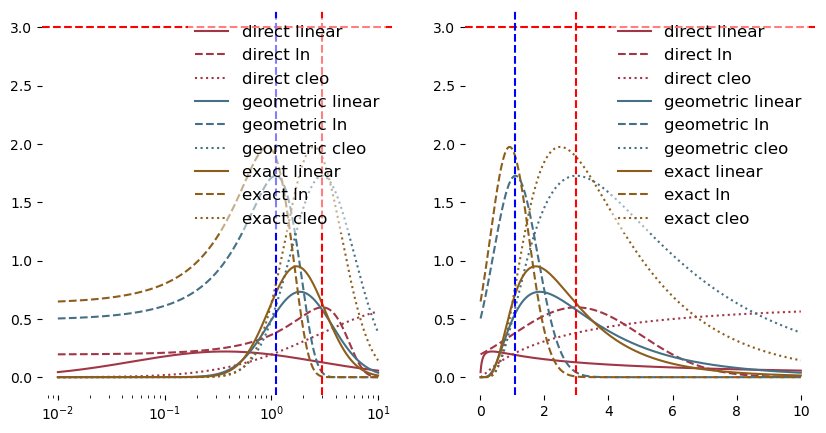

In [4]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))

ax1 = axs[0]
ax2 = axs[1]

i = 0
for ps in ['direct', 'geometric', 'exact']:
    color = dark_colors[i]
    for _ax in axs:
        _ax.plot(x, results[ps]['linear'], label=f'{ps} linear', color = color, linestyle='-')
        _ax.plot(x, results[ps]['ln'], label=f'{ps} ln', color = color, linestyle='--')
        _ax.plot(x, results[ps]['cleo'], label=f'{ps} cleo', color = color, linestyle=':')
    i += 1

for _ax in axs:
    _ax.axvline(params.parameters['mu'], color = 'red', linestyle='--')
    _ax.axhline(params.parameters['scale'], color = 'red', linestyle='--')
    _ax.axvline(np.log(params.parameters['mu']), color = 'blue', linestyle='--')
    _ax.legend()
# ax2.axvline(10, color = 'k', linestyle='--')
# plt.xlim(xlim)
ax1.set_xscale('log')

# ax1.set_ylim(0, 30)


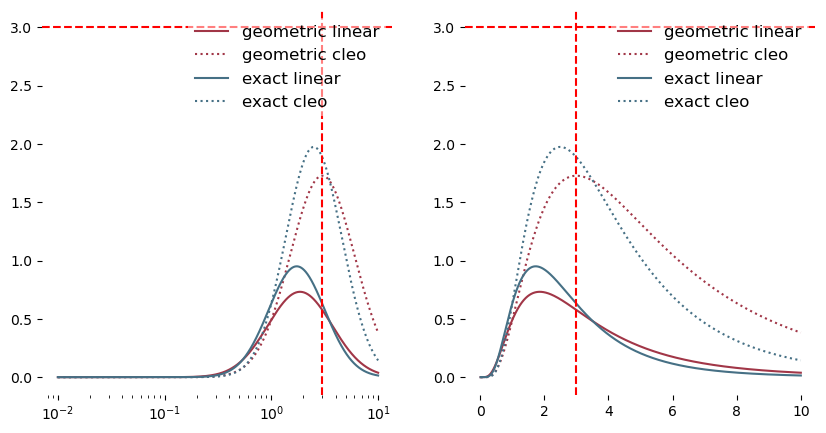

In [5]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))

ax1 = axs[0]
ax2 = axs[1]

i = 0
for ps in ['geometric', 'exact']:
    color = dark_colors[i]
    for _ax in axs:
        _ax.plot(x, results[ps]['linear'], label=f'{ps} linear', color = color, linestyle='-')
        # _ax.plot(x, results[ps]['ln'], label=f'{ps} ln', color = color, linestyle='--')
        _ax.plot(x, results[ps]['cleo'], label=f'{ps} cleo', color = color, linestyle=':')
    i += 1

for _ax in axs:
    _ax.axvline(params.parameters['mu'], color = 'red', linestyle='--')
    _ax.axhline(params.parameters['scale'], color = 'red', linestyle='--')
    # _ax.axvline(np.log(params.parameters['mu']), color = 'blue', linestyle='--')
    _ax.legend()
# ax2.axvline(10, color = 'k', linestyle='--')
# plt.xlim(xlim)
ax1.set_xscale('log')

# ax1.set_ylim(0, 30)


In [6]:
data_dir = RepositoryPath("nils_private").get_data_dir()

cloud_composite = xr.open_dataset(
    data_dir / Path("observation/cloud_composite/processed/cloud_composite_SI_units_20241025.nc")
)
identified_clusters = xr.open_dataset(
    data_dir
    / Path(
        "observation/cloud_composite/processed/identified_clusters/identified_clusters_rain_mask_5.nc"
    )
)
identified_clusters = identified_clusters.swap_dims({"time": "cloud_id"})

attrs = cloud_composite["radius"].attrs.copy()
attrs.update({"units": "µm"})
cloud_composite["radius"] = cloud_composite["radius"]
cloud_composite["radius_micro"] = 1e6 * cloud_composite["radius"]
cloud_composite["radius"].attrs = attrs

cloud_composite["radius2D"] = cloud_composite["radius"].expand_dims(time=cloud_composite["time"])
cloud_composite = cloud_composite.transpose("radius", ...)


# cloud_composite = cloud_composite.sel(radius = slice(10, None))

identified_clusters = identified_clusters.where(
    (
        (identified_clusters.duration.dt.seconds >= 3)
        & (identified_clusters.altitude < 1200)
        & (identified_clusters.altitude > 500)
    ),
    drop=True,
)

If we want to coarsen the results, we need to make sure to apply the coarsening on the **NON** normalized data.
Then we can normalized afterwards again

In [ ]:
radius_split = 95e-6  # 50 µm
coarsen_factor = 3


coarse_composite = cloud_composite.sel(radius=slice(radius_split, None)).copy()

# make sure to have non normalized data to be coarsened
# otherwise, the sum will not be conserved
coarse_composite["particle_size_distribution"] = (
    coarse_composite["particle_size_distribution"] * coarse_composite["bin_width"]
)
coarse_composite["mass_size_distribution"] = (
    coarse_composite["mass_size_distribution"] * coarse_composite["bin_width"]
)

# use mean for radius and radius2D
coarse_composite_radius = coarse_composite["radius"].coarsen(radius=coarsen_factor).mean()
coarse_composite_radius2D = coarse_composite["radius2D"].coarsen(radius=coarsen_factor).mean()
# use the sum for the rest
coarse_composite = coarse_composite.coarsen(radius=coarsen_factor).sum()

coarse_composite["radius"] = coarse_composite_radius
coarse_composite["radius2D"] = coarse_composite_radius2D
coarse_composite["diameter"] = 2 * coarse_composite["radius"]

# make sure to have normalized data again
coarse_composite["particle_size_distribution"] = (
    coarse_composite["particle_size_distribution"] / coarse_composite["bin_width"]
)
coarse_composite["mass_size_distribution"] = (
    coarse_composite["mass_size_distribution"] / coarse_composite["bin_width"]
)

coarse_composite["particle_size_distribution"].attrs = dict(
    long_name="Number concentration",
    unit=cloud_composite["particle_size_distribution"].attrs["unit"],
)
coarse_composite["mass_size_distribution"].attrs = dict(
    long_name="Mass concentration",
    unit=cloud_composite["mass_size_distribution"].attrs["unit"],
)

# merge the two composites with higher resoltion at small radii
# and lower resolution at large radii
coarse_composite = xr.merge(
    [
        coarse_composite.sel(radius=slice(radius_split, None)),
        cloud_composite.sel(radius=slice(None, radius_split)),
    ]
)


# Test liquid water content is conserved
np.testing.assert_allclose(
    (coarse_composite["bin_width"] * coarse_composite["mass_size_distribution"]).sum("radius"),
    (cloud_composite["bin_width"] * cloud_composite["mass_size_distribution"]).sum("radius"),
    rtol=0.001,
)
# Test particle concentration is conserved
np.testing.assert_allclose(
    (coarse_composite["bin_width"] * coarse_composite["particle_size_distribution"]).sum("radius"),
    (cloud_composite["bin_width"] * cloud_composite["particle_size_distribution"]).sum("radius"),
    rtol=0.001,
)

In [ ]:

class PSDBounds():
    
    mu1 = np.array([1e-6, 3e-6, 10e-6])
    sig1 = np.array([1.1, 2, 4])
    sc1 = np.array([0, 1e10, 1e16])
    mu2 = np.array([200e-6, 300e-6, 500e-6])
    sig2 = np.array([1.1, 2, 3])
    sc2 = np.array([0, 1e6, 1e10])


    _x0 = np.array(
        [mu1[1], sig1[1], sc1[1], mu2[1], sig2[1], sc2[1]]
    )

    _x0_micrometer = np.array(
        [mu1[1]*1e6, sig1[1], sc1[1], mu2[1]*1e6, sig2[1], sc2[1]]
    )

    _bounds = Bounds(
        # mu1, sig1, sc1, mu2, sig2, sc2
        lb=[mu1[0], sig1[0], sc1[0], mu2[0], sig2[0], sc2[0]],
        ub=[mu1[2], sig1[2], sc1[2], mu2[2], sig2[2], sc2[2]],
        # keep_feasible = [True, True, True, False, True, True]
        )
    
    _bounds_micrometer = Bounds(
        # mu1, sig1, sc1, mu2, sig2, sc2
        lb=[mu1[0]*1e6, sig1[0], sc1[0], mu2[0]*1e6, sig2[0], sc2[0]],
        ub=[mu1[2]*1e6, sig1[2], sc1[2], mu2[2]*1e6, sig2[2], sc2[2]],
        # keep_feasible = [True, True, True, False, True, True]
        )

    @staticmethod
    def bounds():
        return PSDBounds._bounds
    
    @staticmethod
    def bounds_micrometer():
        return PSDBounds._bounds_micrometer
    
    @staticmethod
    def x0():
        return PSDBounds._x0

    @staticmethod
    def x0_micrometer():
        return PSDBounds._x0_micrometer
    
class MSDBounds():
    
    mu1 = np.array([1e-6, 3e-6, 10e-6])
    sig1 = np.array([1.1, 2.0, 4.0])
    sc1 = np.array([0, 1e-1, 1e2])
    mu2 = np.array([200e-6, 300e-6, 500e-6])
    sig2 = np.array([1.3, 2, 3.0])
    sc2 = np.array([0, 1e-3, 1e1])


    _x0 = np.array(
        [mu1[1], sig1[1], sc1[1], mu2[1], sig2[1], sc2[1]]
    )

    _x0_micrometer = np.array(
        [mu1[1]*1e6, sig1[1], sc1[1], mu2[1]*1e6, sig2[1], sc2[1]]
    )

    _bounds = Bounds(
        # mu1, sig1, sc1, mu2, sig2, sc2
        lb=[mu1[0], sig1[0], sc1[0], mu2[0], sig2[0], sc2[0]],
        ub=[mu1[2], sig1[2], sc1[2], mu2[2], sig2[2], sc2[2]],
        # keep_feasible = [True, True, True, False, True, True]
        )
    
    _bounds_micrometer = Bounds(
        # mu1, sig1, sc1, mu2, sig2, sc2
        lb=[mu1[0]*1e6, sig1[0], sc1[0], mu2[0]*1e6, sig2[0], sc2[0]],
        ub=[mu1[2]*1e6, sig1[2], sc1[2], mu2[2]*1e6, sig2[2], sc2[2]],
        # keep_feasible = [True, True, True, False, True, True]
        )

    @staticmethod
    def bounds():
        return MSDBounds._bounds
    
    @staticmethod
    def bounds_micrometer():
        return MSDBounds._bounds_micrometer
    
    @staticmethod
    def x0():
        return MSDBounds._x0

    @staticmethod
    def x0_micrometer():
        return MSDBounds._x0_micrometer
    

In [ ]:
from numpy import ndarray

from importlib import reload
reload(smodels)


class DoubleLnNormalLeastSquare(smodels.LeastSquareFit):
    """
    A class to perform least squares fitting for a double log-normal distribution.

    Attributes:
        name (str): The name of the fitting instance.
        func (Callable): The model function to fit.
        cost_func (Callable): The cost function to minimize.
        x0 (np.ndarray): Initial guess for the parameters.
        bounds (Bounds): Bounds on the parameters.
        t_train (Union[np.ndarray, xr.DataArray]): Training data for the independent variable.
        y_train (Union[np.ndarray, xr.DataArray]): Training data for the dependent variable.
        fit_kwargs (Dict): Additional keyword arguments for the least_squares function.
        plot_kwargs (Dict): Additional keyword arguments for plotting.
        fit_result: The result of the fitting process.

    Methods:

    """

    def __init__(
        self,
        name: str,
        x0: np.ndarray,
        bounds: Bounds,
        t_train: np.ndarray,
        y_train: np.ndarray,
        fit_kwargs: Dict = dict(),
        plot_kwargs: Dict = dict(),
    ):
        """
        Initialize the DoubleLnNormalLeastSquare instance.

        Parameters:
            name (str): The name of the fitting instance.
            x0 (np.ndarray): Initial guess for the parameters.
            bounds (Bounds): Bounds on the parameters.
            t_train (np.ndarray): Training data for the independent variable.
            y_train (np.ndarray): Training data for the dependent variable.
        """

        def this_func(
            t: ndarray,
            mu1: float,
            sigma1: float,
            scale_factor1: float,
            mu2: float,
            sigma2: float,
            scale_factor2: float,
        ) -> np.ndarray:
            

            d1 = smodels.log_normal_distribution_all(
                x=t,
                mu = mu1,
                sigma = sigma1,
                scale = scale_factor1,
                parameter_space="geometric",
                space="cleo",
            )
            d2 = smodels.log_normal_distribution_all(
                x=t,
                mu = mu2,
                sigma = sigma2,
                scale = scale_factor2,
                parameter_space="geometric",
                space="cleo",
            )

            return d1 + d2

        super().__init__(
            name=name,
            func=this_func,
            x0=x0,
            bounds=bounds,
            t_train=t_train,
            y_train=y_train,
            fit_kwargs=fit_kwargs,
            plot_kwargs=plot_kwargs,
        )

        self.cost_func = self.__default_cost_func__

    def __default_cost_func__(self, x: np.ndarray, t: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
        """
        The cost function to minimize.

        Parameters:
            x (np.ndarray): The parameters to estimate.
            t (np.ndarray): The independent variable.
            y (np.ndarray): The dependent variable.

        Returns:
            np.ndarray: The difference between the predicted and the actual data.
        """
        diff = y - self.func(t, *x)

        diff = np.ravel(diff)

        # only use the non-NaN values
        idx = np.where(~np.isnan(diff))
        diff = diff[idx]
        return diff


class BasicDoubleLnNormalLeastSquare(smodels.LeastSquareFit):
    """
    A class to perform least squares fitting for a double log-normal distribution.

    Attributes:
        name (str): The name of the fitting instance.
        func (Callable): The model function to fit.
        cost_func (Callable): The cost function to minimize.
        x0 (np.ndarray): Initial guess for the parameters.
        bounds (Bounds): Bounds on the parameters.
        t_train (Union[np.ndarray, xr.DataArray]): Training data for the independent variable.
        y_train (Union[np.ndarray, xr.DataArray]): Training data for the dependent variable.
        fit_kwargs (Dict): Additional keyword arguments for the least_squares function.
        plot_kwargs (Dict): Additional keyword arguments for plotting.
        fit_result: The result of the fitting process.

    Methods:

    """

    def __init__(
        self,
        name: str,
        x0: np.ndarray,
        bounds: Bounds,
        t_train: np.ndarray,
        y_train: np.ndarray,
        fit_kwargs: Dict = dict(),
        plot_kwargs: Dict = dict(),
    ):
        """
        Initialize the DoubleLnNormalLeastSquare instance.

        Parameters:
            name (str): The name of the fitting instance.
            x0 (np.ndarray): Initial guess for the parameters.
            bounds (Bounds): Bounds on the parameters.
            t_train (np.ndarray): Training data for the independent variable.
            y_train (np.ndarray): Training data for the dependent variable.
        """

        def this_func(
            t: ndarray,
            mu1: float,
            sigma1: float,
            scale_factor1: float,
            mu2: float,
            sigma2: float,
            scale_factor2: float,
        ) -> np.ndarray:
            

            d1 = smodels.double_ln_normal_distribution(
                t=t,
                mu1 = mu1,
                sigma1 = sigma1,
                scale_factor1 = scale_factor1,
                mu2 = mu2,
                sigma2 = sigma2,
                scale_factor2 = scale_factor2,
            )

            return d1

        super().__init__(
            name=name,
            func=this_func,
            x0=x0,
            bounds=bounds,
            t_train=t_train,
            y_train=y_train,
            fit_kwargs=fit_kwargs,
            plot_kwargs=plot_kwargs,
        )

        self.cost_func = self.__default_cost_func__

    def __default_cost_func__(self, x: np.ndarray, t: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
        """
        The cost function to minimize.

        Parameters:
            x (np.ndarray): The parameters to estimate.
            t (np.ndarray): The independent variable.
            y (np.ndarray): The dependent variable.

        Returns:
            np.ndarray: The difference between the predicted and the actual data.
        """
        diff = y - self.func(t, *x)

        diff = np.ravel(diff)

        # only use the non-NaN values
        idx = np.where(~np.isnan(diff))
        diff = diff[idx]
        return diff


class WeightedDoubleLnNormalLeastSquare(smodels.LeastSquareFit):
    """
    A class to perform least squares fitting for a double log-normal distribution.

    Attributes:
        name (str): The name of the fitting instance.
        func (Callable): The model function to fit.
        cost_func (Callable): The cost function to minimize.
        x0 (np.ndarray): Initial guess for the parameters.
        bounds (Bounds): Bounds on the parameters.
        t_train (Union[np.ndarray, xr.DataArray]): Training data for the independent variable.
        y_train (Union[np.ndarray, xr.DataArray]): Training data for the dependent variable.
        fit_kwargs (Dict): Additional keyword arguments for the least_squares function.
        plot_kwargs (Dict): Additional keyword arguments for plotting.
        fit_result: The result of the fitting process.

    Methods:

    """

    def __init__(
        self,
        name: str,
        x0: np.ndarray,
        bounds: Bounds,
        t_train: np.ndarray,
        y_train: np.ndarray,
        fit_kwargs: Dict = dict(),
        plot_kwargs: Dict = dict(),
    ):
        """
        Initialize the DoubleLnNormalLeastSquare instance.

        Parameters:
            name (str): The name of the fitting instance.
            x0 (np.ndarray): Initial guess for the parameters.
            bounds (Bounds): Bounds on the parameters.
            t_train (np.ndarray): Training data for the independent variable.
            y_train (np.ndarray): Training data for the dependent variable.
        """

        def this_func(
            t: ndarray,
            mu1: float,
            sigma1: float,
            scale_factor1: float,
            mu2: float,
            sigma2: float,
            scale_factor2: float,
        ) -> np.ndarray:
            

            d1 = smodels.log_normal_distribution_all(
                x=t,
                mu = mu1,
                sigma = sigma1,
                scale = scale_factor1,
                parameter_space="geometric",
                space="cleo",
            )
            d2 = smodels.log_normal_distribution_all(
                x=t,
                mu = mu2,
                sigma = sigma2,
                scale = scale_factor2,
                parameter_space="geometric",
                space="cleo",
            )

            return d1 + d2

        super().__init__(
            name=name,
            func=this_func,
            x0=x0,
            bounds=bounds,
            t_train=t_train,
            y_train=y_train,
            fit_kwargs=fit_kwargs,
            plot_kwargs=plot_kwargs,
        )

        self.cost_func = self.__default_cost_func__

    def __default_cost_func__(self, x: np.ndarray, t: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
        """
        The cost function to minimize.

        Parameters:
            x (np.ndarray): The parameters to estimate.
            t (np.ndarray): The independent variable.
            y (np.ndarray): The dependent variable.

        Returns:
            np.ndarray: The difference between the predicted and the actual data.
        """
        diff = t**3 * (y - self.func(t, *x))
        # diff = y - self.func(t, *x)

        diff = np.ravel(diff)

        # only use the non-NaN values
        idx = np.where(~np.isnan(diff))
        diff = diff[idx]
        return diff


# New approach:

- limit radius range to 15µm to None

In [ ]:
list_lwc = []
list_lwc_sem = []

for cloud_id in tqdm(identified_clusters['cloud_id']):
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id = cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    lwc = cc["liquid_water_content"]

    lwc_mean, lwc_sem = mean_and_stderror_of_mean(lwc, dims = ('time', ))
    list_lwc.append(lwc_mean)
    list_lwc_sem.append(lwc_sem)

da_lwc = xr.concat(
    list_lwc,
    dim = 'cloud_id',
    )
da_lwc_sem = xr.concat(
    list_lwc_sem,
    dim = 'cloud_id',
    )


100%|██████████| 154/154 [00:03<00:00, 38.85it/s]


### Fit all clouds

In [ ]:
start = 1e-6
end = 1.5e-3
r = np.geomspace(start, end, 1000)
t_test = xr.DataArray(data=r, coords={"radius": r}, dims=["radius"])
w_test = 0.5 * (t_test - t_test.shift(radius=2)).shift(radius=-1)
t_test = t_test.isel(radius=slice(1, -1))
w_test = w_test.isel(radius=slice(1, -1))


#### Fit in number concentration space

In [ ]:
number_concentration_parameters = dict()
fitted_data = []


for cloud_id in tqdm(identified_clusters['cloud_id']):

    # extract the cloud composite data for the cloud
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id = cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    # use the particle size distribution and the radius
    psd = cc["particle_size_distribution"]#.sel(radius = slice(15e-6, None))
    radius = cc["radius"].expand_dims(time = cc["time"]) #.sel(radius = slice(15e-6, None))

    # make sure to have the same order of dimensions
    psd = psd.transpose("time", "radius")
    radius = radius.transpose("time", "radius")

    # fit the double log-normal distribution
    double_ln = BasicDoubleLnNormalLeastSquare(
        name = 'PSD',
        x0 = PSDBounds.x0(),
        bounds = PSDBounds.bounds(),
        t_train = radius.mean('time', skipna = True),
        y_train = psd.mean('time', skipna = True),
        fit_kwargs=dict(loss="linear", kwargs=dict(variance=1)),
    )
    double_ln.fit(10)

    # save the parameters
    number_concentration_parameters[str(cloud_id)] = double_ln.parameters


    # predict the number concentration
    r, p = double_ln.predict(t_test)

    # make sure to only sample the fitted data where the radius is smaller than the maximum radius

    radii_measured = psd.max("time") > 0
    end = psd["radius"].where(radii_measured).max("radius")
    start = psd["radius"].where(radii_measured).min("radius")

    p = p.where(r < end, other = np.nan)

    fitted_data.append(p)
    

# create a data array with the fitted number concentration
number_concentration_fitted_data = xr.concat(
    fitted_data,
    dim = 'cloud_id',
    )
number_concentration_fitted_data['cloud_id'] = identified_clusters['cloud_id']

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:25<00:00,  6.04it/s]


In [ ]:
weighted_number_concentration_parameters = dict()
fitted_data = []


for cloud_id in tqdm(identified_clusters['cloud_id']):

    # extract the cloud composite data for the cloud
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id = cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    # use the particle size distribution and the radius
    psd = cc["particle_size_distribution"]#.sel(radius = slice(15e-6, None))
    radius = cc["radius"].expand_dims(time = cc["time"]) #.sel(radius = slice(15e-6, None))

    # make sure to have the same order of dimensions
    psd = psd.transpose("time", "radius")
    radius = radius.transpose("time", "radius")

    # fit the double log-normal distribution
    double_ln = WeightedDoubleLnNormalLeastSquare(
        name = 'PSD',
        x0 = PSDBounds.x0(),
        bounds = PSDBounds.bounds(),
        t_train = radius.mean('time', skipna = True),
        y_train = psd.mean('time', skipna = True),
        fit_kwargs=dict(loss="linear", kwargs=dict(variance=1)),

    )
    double_ln.fit(10)

    # save the parameters
    weighted_number_concentration_parameters[str(cloud_id)] = double_ln.parameters


    # predict the number concentration
    r, p = double_ln.predict(t_test)

    # make sure to only sample the fitted data where the radius is smaller than the maximum radius
    radii_measured = psd.max("time") > 0
    end = psd["radius"].where(radii_measured).max("radius")
    start = psd["radius"].where(radii_measured).min("radius")

    p = p.where(r < end, other = np.nan)

    fitted_data.append(p)
    

# create a data array with the fitted number concentration
weighted_number_concentration_fitted_data = xr.concat(
    fitted_data,
    dim = 'cloud_id',
    )
weighted_number_concentration_fitted_data['cloud_id'] = identified_clusters['cloud_id']

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:30<00:00,  5.12it/s]


#### Fit in mass concentration space

In [ ]:
mass_concentration_parameters = dict()
fitted_data = []

for cloud_id in tqdm(identified_clusters['cloud_id']):

    # extract the cloud composite data for the cloud
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id = cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    # use the mass size distribution and the radius
    msd = cc["mass_size_distribution"]#.sel(radius = slice(15e-6, None))
    radius = cc["radius"].expand_dims(time = cc["time"]) #.sel(radius = slice(15e-6, None))

    # make sure to have the same order of dimensions
    msd = msd.transpose("time", "radius")
    radius = radius.transpose("time", "radius")

    # fit the double log-normal distribution
    double_ln = BasicDoubleLnNormalLeastSquare(
        name = 'MSD',
        x0 = MSDBounds.x0(),
        bounds = MSDBounds.bounds(),
        t_train = radius.mean('time', skipna = True),
        y_train = msd.mean('time', skipna = True),
        fit_kwargs=dict(loss="linear", kwargs=dict(variance=1)),
    )
    double_ln.fit(10)

    # save the parameters
    mass_concentration_parameters[str(cloud_id)] = double_ln.parameters

    # predict the mass concentration
    r, p = double_ln.predict(t_test)

    # make sure to only sample the fitted data where the radius is smaller than the maximum radius
    radii_measured = msd.max("time") > 0
    end = msd["radius"].where(radii_measured).max("radius")
    start = msd["radius"].where(radii_measured).min("radius")

    p = p.where(r < end, other = np.nan)

    fitted_data.append(p)
    
# create a data array with the fitted mass concentration
mass_concentration_fitted_data = xr.concat(
    fitted_data,
    dim = 'cloud_id',
    )
mass_concentration_fitted_data['cloud_id'] = identified_clusters['cloud_id']

100%|██████████| 154/154 [00:21<00:00,  7.26it/s]


#### Combine the data into one dataset

In [ ]:
# combine the datasets
dataset_fitted = xr.Dataset(
    dict(
        number_concentration = number_concentration_fitted_data,
        weighted_number_concentration = weighted_number_concentration_fitted_data,
        mass_concentration = mass_concentration_fitted_data,
    )
)
dataset_fitted['bin_width'] = w_test
dataset_fitted['bin_width'].attrs = dict(
    long_name = 'Bin width',
    unit = 'm',
)

dataset_fitted['number_concentration'].attrs = dict(
    long_name = 'Number concentration',
    unit = 'm^{-3} m^{-1}',
)

dataset_fitted['weighted_number_concentration'].attrs = dict(
    long_name = 'Weighted number concentration',
    unit = 'm^{-3} m^{-1}',
)

dataset_fitted['mass_concentration'].attrs = dict(
    long_name = 'Mass concentration',
    unit = 'kg m^{-3} m^{-1}',
)


dataset_fitted['mass_concentration_from_nc'] = msd_from_psd_dataarray(
    da = dataset_fitted['number_concentration'] * dataset_fitted['bin_width'],
) / dataset_fitted['bin_width']
dataset_fitted['mass_concentration_from_nc'].attrs = dict(
    long_name = 'Mass concentration from number concentration',
    unit = 'kg m^{-3} m^{-1}',
)

dataset_fitted['mass_concentration_from_wnc'] = msd_from_psd_dataarray(
    da = dataset_fitted['weighted_number_concentration'] * dataset_fitted['bin_width'],
) / dataset_fitted['bin_width']
dataset_fitted['mass_concentration_from_wnc'].attrs = dict(
    long_name = 'Mass concentration from weighted number concentration',
    unit = 'kg m^{-3} m^{-1}',
)

dataset_fitted['number_concentration_from_mc'] = psd_from_msd_dataarray(
    da = dataset_fitted['mass_concentration'] * dataset_fitted['bin_width'],
) / dataset_fitted['bin_width']
dataset_fitted['number_concentration_from_mc'].attrs = dict(
    long_name = 'Number concentration from mass concentration',
    unit = 'm^{-3} m^{-1}',
)

colors = dict(
    number_concentration = default_colors[0],
    mass_concentration_from_nc = dark_colors[0],
    weighted_number_concentration = default_colors[1],
    mass_concentration_from_wnc = dark_colors[1],
    number_concentration_from_mc = dark_colors[3],
    mass_concentration = default_colors[3],
)


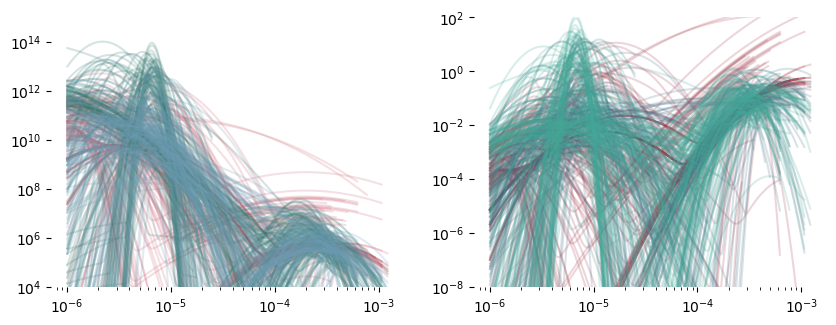

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 3.5))


axs[0].plot(
    dataset_fitted['radius'],
    dataset_fitted['number_concentration'].T,
    color = colors['number_concentration'],
    alpha = 0.2,
)

axs[0].plot(
    dataset_fitted['radius'],
    dataset_fitted['number_concentration_from_mc'].T,
    color = colors['number_concentration_from_mc'],
    alpha = 0.2,
)

axs[0].plot(
    dataset_fitted['radius'],
    dataset_fitted['weighted_number_concentration'].T,
    color = colors['weighted_number_concentration'],
    alpha = 0.2,
)

axs[0].set_ylim(1e4, 1e15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].plot(
    dataset_fitted['radius'],
    dataset_fitted['mass_concentration_from_nc'].T,
    color = colors['mass_concentration_from_nc'],
    alpha = 0.2,
)

axs[1].plot(
    dataset_fitted['radius'],
    dataset_fitted['mass_concentration_from_wnc'].T,
    color = colors['mass_concentration_from_wnc'],
    alpha = 0.2,
)

axs[1].plot(
    dataset_fitted['radius'],
    dataset_fitted['mass_concentration'].T,
    color = colors['mass_concentration'],
    alpha = 0.2,
)
axs[1].set_ylim(1e-8, 1e2)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

Text(0, 0.5, 'Mass concentration\n[kg m$^{-3}$ m$^{-1}$]')

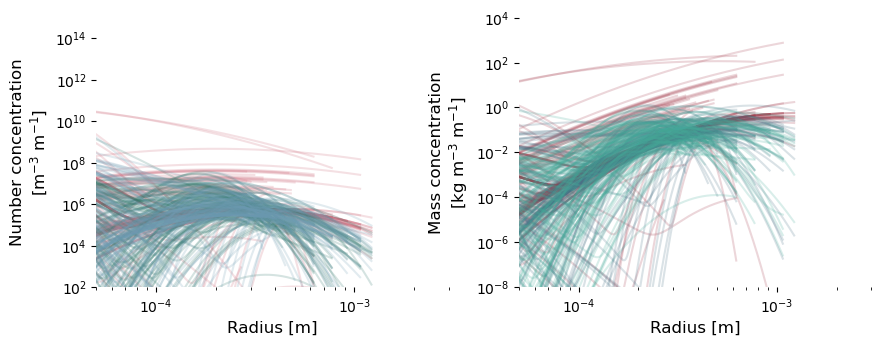

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 3.5))


axs[0].plot(
    dataset_fitted['radius'],
    dataset_fitted['number_concentration'].T,
    color = colors['number_concentration'],
    alpha = 0.2,
)

axs[0].plot(
    dataset_fitted['radius'],
    dataset_fitted['number_concentration_from_mc'].T,
    color = colors['number_concentration_from_mc'],
    alpha = 0.2,
)

axs[0].plot(
    dataset_fitted['radius'],
    dataset_fitted['weighted_number_concentration'].T,
    color = colors['weighted_number_concentration'],
    alpha = 0.2,
)

axs[0].set_ylim(1e2, 1e15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].plot(
    dataset_fitted['radius'],
    dataset_fitted['mass_concentration_from_nc'].T,
    color = colors['mass_concentration_from_nc'],
    alpha = 0.2,
)

axs[1].plot(
    dataset_fitted['radius'],
    dataset_fitted['mass_concentration_from_wnc'].T,
    color = colors['mass_concentration_from_wnc'],
    alpha = 0.2,
)

axs[1].plot(
    dataset_fitted['radius'],
    dataset_fitted['mass_concentration'].T,
    color = colors['mass_concentration'],
    alpha = 0.2,
)
axs[1].set_ylim(1e-8, 1e4)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

for ax in axs:
    ax.set_xlim(50e-6, 3e-3)
    ax.set_xlabel('Radius [m]')

axs[0].set_ylabel('Number concentration\n[m$^{-3}$ m$^{-1}$]')
axs[1].set_ylabel('Mass concentration\n[kg m$^{-3}$ m$^{-1}$]')

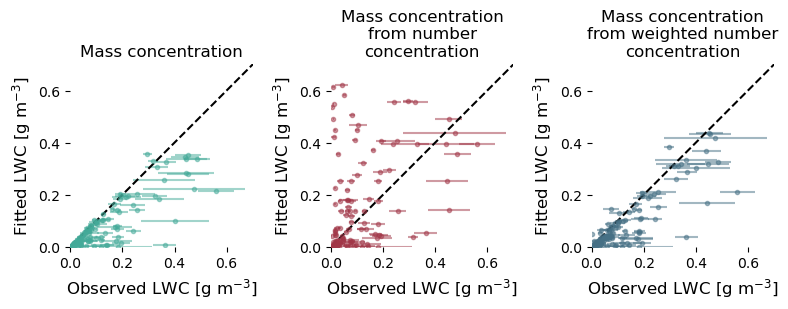

In [ ]:
fig, axs = plt.subplots(ncols = 3, figsize = (8, 3.5))

i = 0
for key in (
    'mass_concentration',
    'mass_concentration_from_nc',
    'mass_concentration_from_wnc',
) :

    axs[i].errorbar(
        x = da_lwc,
        xerr = da_lwc_sem,
        y = 2 * 1e3 * (dataset_fitted[key] * dataset_fitted['bin_width']).sel(radius = slice(50e-6, None)).sum('radius'),
        yerr = 0,
        marker = '.',
        linestyle = 'None',
        label = dataset_fitted[key].attrs['long_name'],
        color = colors[key],
        alpha = 0.5
    )
    axs[i].set_title(label_from_attrs(dataset_fitted[key], return_units = False, name_width=20))
    i += 1
    
for _ax in axs : 
    _ax.plot(
        [0, 3],
        [0, 3],
        color = 'black',
        linestyle = '--'
    )

    _ax.set_xlim(0, 0.7)
    _ax.set_ylim(0, 0.7)
    _ax.set_aspect('equal')
    _ax.set_xlabel('Observed LWC [g m$^{-3}$]')
    _ax.set_ylabel('Fitted LWC [g m$^{-3}$]')

fig.tight_layout()

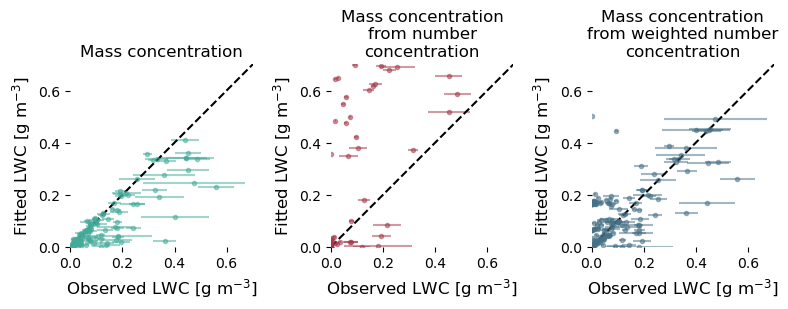

In [ ]:
fig, axs = plt.subplots(ncols = 3, figsize = (8, 3.5))

i = 0
for key in (
    'mass_concentration',
    'mass_concentration_from_nc',
    'mass_concentration_from_wnc',
) :

    axs[i].errorbar(
        x = da_lwc,
        xerr = da_lwc_sem,
        y = 2 * 1e3 * (dataset_fitted[key] * dataset_fitted['bin_width']).sel(radius = slice(50e-6, None)).sum('radius'),
        yerr = 0,
        marker = '.',
        linestyle = 'None',
        label = dataset_fitted[key].attrs['long_name'],
        color = colors[key],
        alpha = 0.5
    )
    axs[i].set_title(label_from_attrs(dataset_fitted[key], return_units = False, name_width=20))
    i += 1
    
for _ax in axs : 
    _ax.plot(
        [0, 3],
        [0, 3],
        color = 'black',
        linestyle = '--'
    )

    _ax.set_xlim(0, 0.7)
    _ax.set_ylim(0, 0.7)
    _ax.set_aspect('equal')
    _ax.set_xlabel('Observed LWC [g m$^{-3}$]')
    _ax.set_ylabel('Fitted LWC [g m$^{-3}$]')

fig.tight_layout()

In [ ]:
import matplotlib.colors as mcolors

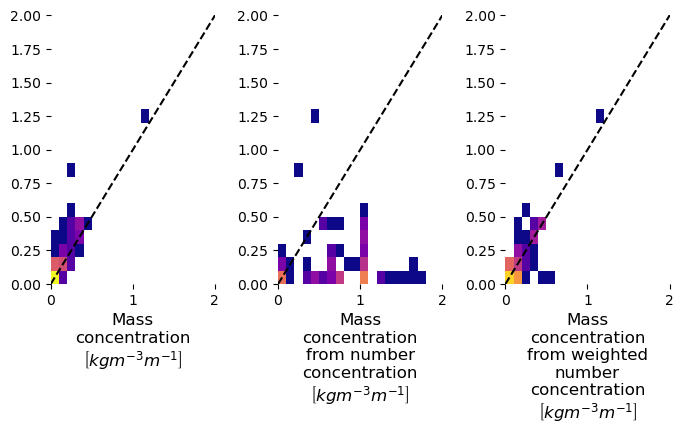

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (7, 4.5))
i = 0
for key in (
    'mass_concentration',
    'mass_concentration_from_nc',
    'mass_concentration_from_wnc',
) :

    axs[i].hist2d(
        2 * 1e3 * (dataset_fitted[key] * dataset_fitted['bin_width']).sel(radius = slice(50e-6, None)).sum('radius'),
        da_lwc,
        bins = np.arange(0,10,0.1),
        cmap = 'plasma',
        norm = mcolors.LogNorm(vmin = 1, vmax = 100),
    )
    # axs[i].set_ylabel(label_from_attrs(da_lwc))
    axs[i].set_xlabel(label_from_attrs(dataset_fitted[key], name_width=15, linebreak=True))
    i += 1

for _ax in axs :
    _ax.plot(
        [0, 3],
        [0, 3],
        color = 'black',
        linestyle = '--'
    )

    _ax.set_xlim(0, 2)
    _ax.set_ylim(0, 2)

fig.tight_layout()

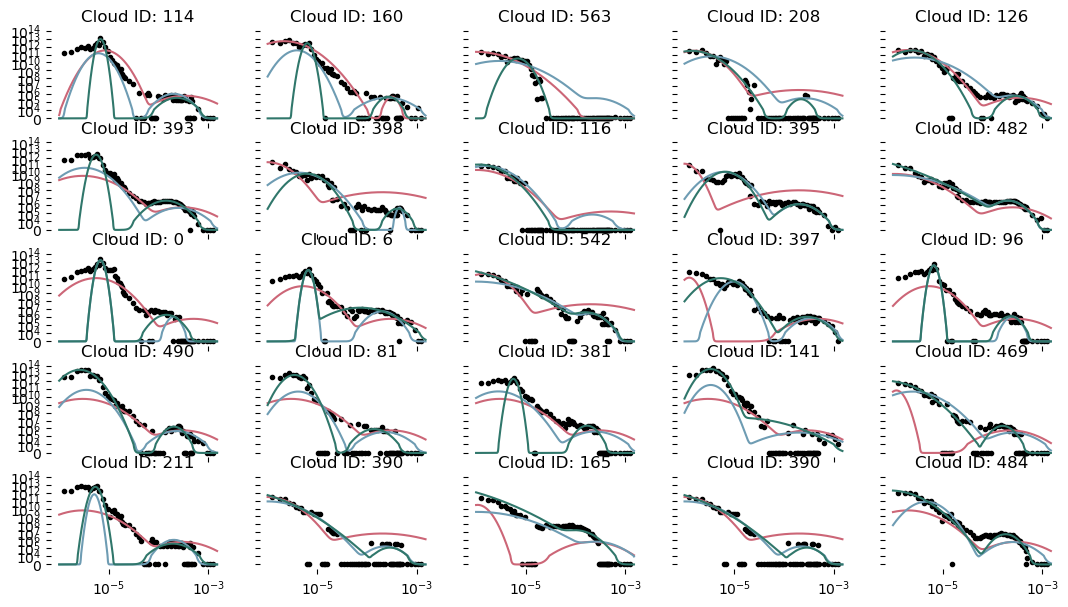

In [ ]:
cloud_ids = np.random.choice(identified_clusters['cloud_id'], 25)

fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (13, 7), sharex = True, sharey = True)

# plot the PSDs of the selected clouds
for i, cloud_id in enumerate(cloud_ids):
    _ax = axs.flatten()[i]
    _ax.set_title(f'Cloud ID: {cloud_id}')
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id = cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    observations = cc['particle_size_distribution']
    
    _ax.plot(
        observations['radius'],
        observations.mean('time'),
        marker = '.',
        linestyle = 'None',
        color = 'black'
    )
    
    for key in (
        'number_concentration',
        'weighted_number_concentration',
        'number_concentration_from_mc',
    ):
    
        fit = dataset_fitted[key].sel(cloud_id = cloud_id)
        _ax.plot(
            fit['radius'],
            fit,
            color = colors[key],
            linestyle = '-',
        )

    _ax.set_xscale('log')
_ax.set_yscale('symlog', linthresh = 1e4)
# _ax.set_ylim(0, None)




(0.0, 10.0)

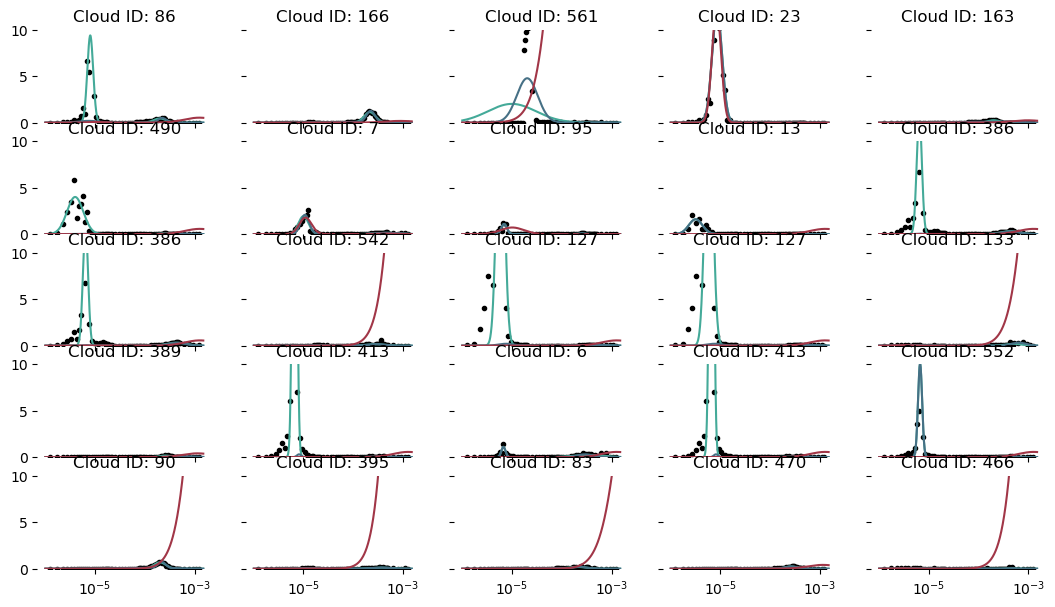

In [ ]:
cloud_ids = np.random.choice(identified_clusters['cloud_id'], 25)

fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (13, 7), sharex = True, sharey = True)

# plot the PSDs of the selected clouds
for i, cloud_id in enumerate(cloud_ids):
    _ax = axs.flatten()[i]
    _ax.set_title(f'Cloud ID: {cloud_id}')
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id = cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    observations = cc['mass_size_distribution']
    
    _ax.plot(
        observations['radius'],
        observations.mean('time'),
        marker = '.',
        linestyle = 'None',
        color = 'black'
    )
    
    for key in (
        'mass_concentration',
        'mass_concentration_from_wnc',
        'mass_concentration_from_nc',
    ):
    
        fit = dataset_fitted[key].sel(cloud_id = cloud_id)
        _ax.plot(
            fit['radius'],
            fit,
            color = colors[key],
            linestyle = '-',
        )

    _ax.set_xscale('log')
# _ax.set_yscale('symlog', linthresh = 1e4)
_ax.set_ylim(0, 10)




(0.0, 0.01)

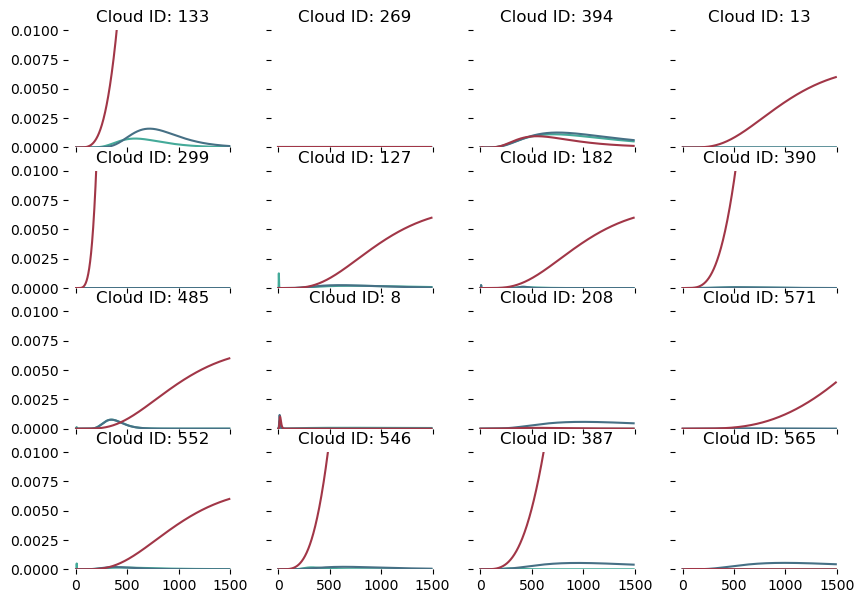

In [ ]:
cloud_ids = np.random.choice(identified_clusters['cloud_id'], 16)

fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (10, 7), sharex = True, sharey = True)

# plot the PSDs of the selected clouds
for i, cloud_id in enumerate(cloud_ids):
    _ax = axs.flatten()[i]
    _ax.set_title(f'Cloud ID: {cloud_id}')
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id = cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    observations = cc['mass_size_distribution'] * cc['bin_width']
    
    # _ax.plot(
    #     observations['radius'],
    #     1e3 * observations.mean('time'),
    #     marker = '.',
    #     linestyle = 'None',
    #     color = 'black'
    # )
    
    for key in (
        'mass_concentration',
        'mass_concentration_from_wnc',
        'mass_concentration_from_nc',
    ):
    
        dsf = dataset_fitted.sel(cloud_id = cloud_id)
        fit = dsf[key] * dsf['bin_width']
        _ax.plot(
            1e6 * fit['radius'],
            1e3 * fit,
            color = colors[key],
            linestyle = '-',
        )

_ax.set_ylim(0, 0.01)


